**Introduction**

One of the most important things to do is to predict how the stock market will do. Physical vs. psychological factors, rational vs. irrational behavior, and so on are all factors in the prediction. Both of these factors combine to make stock prices extremely volatile and difficult to forecast accurately.

Fundamental and technical analysis are the two main components of stock market analysis.

Fundamental analysis is the process of determining a company's potential viability based on its existing market environment and financial results.

Technical analysis, on the other hand, entails reading charts and analyzing statistical data to determine stock market patterns.


**PART 1: SETTING UP COLAB.** 

Tensorflow version 1.x

In [ ]:
%tensorflow_version 1.x

Importing all the libraries and dependencies required

In [ ]:
#import libraries
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pylab import rcParams

In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
#declare name of your device and drive location select GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.

Copy paste that code in the text box that will appear below

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


The CSV file is located in a subdirectory.

In [ ]:
#name of your google path
googlepath = "/content/drive/My Drive"

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.

High and Low represent the maximum and minimum price of the share for the day respectively.

In [ ]:
#Get your API data
file_name="AMZN.csv"
# file_name="DAL.csv"
# file_name="NFLX.csv"
# file_name="UAL.csv"
df = pd.read_csv(os.path.join(f'{googlepath}',f'{file_name}'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [ ]:
df = df.sort_values('Date')
df.head(), len(df)
# print(df.iloc[-330,:])
# df=df.iloc[:,:100]

(         Date        Open        High         Low       Close
 0  2016-05-11  705.789978  719.000000  701.650024  713.229980
 1  2016-05-12  717.380005  722.450012  711.510010  717.929993
 2  2016-05-13  714.640015  719.250000  706.510010  709.919983
 3  2016-05-16  710.130005  713.250000  700.280029  710.659973
 4  2016-05-17  709.900024  714.469971  693.909973  695.270020, 1258)

**FIND AVERAGE PRICE OF THE HIGH AND LOW PRICES AND USE THAT TO PLOT.**

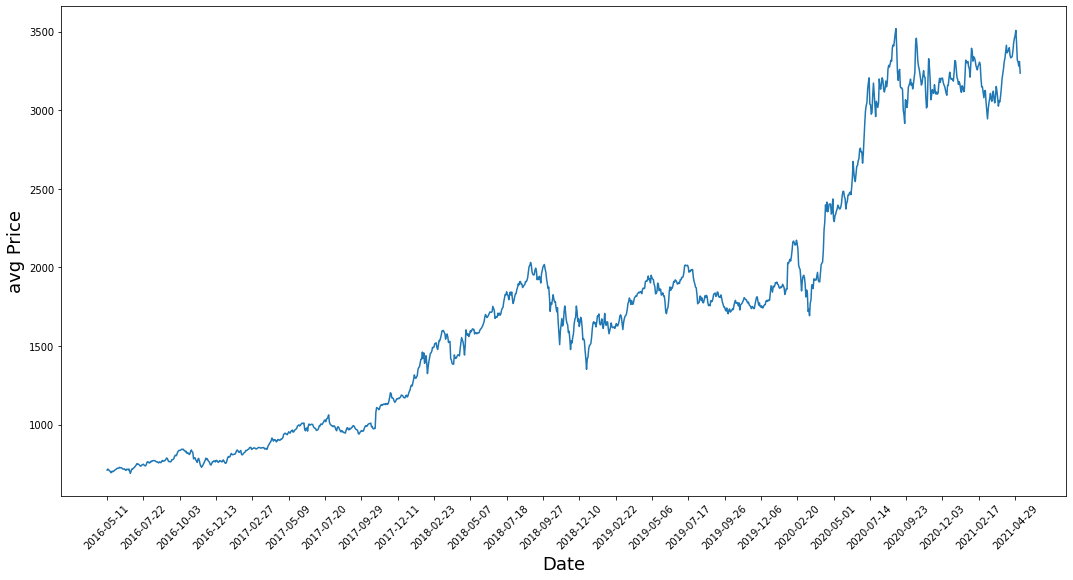

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.show()

In [ ]:
# First calculate the average prices from the highest and lowest 
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
avg_prices = (high_prices+low_prices)/2.0

In [ ]:
high_prices

array([ 719.      ,  722.450012,  719.25    ,  713.25    , ..., 3354.699951, 3314.399902, 3330.889893, 3283.      ])

In [ ]:
train_size=817
test_size=440
start_date=0

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

The input gate: The input gate adds information to the cell state

The forget gate: It removes the information that is no longer required by the model

The output gate: Output Gate at LSTM selects the information to be shown as output

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1)) #use mimaxscaler from scikitlearn to normalize data


In [ ]:
df1=avg_prices[start_date:train_size+start_date+test_size]
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

train = df1[0:train_size,:1]
test = df1[train_size:train_size+test_size,:1]

(df1)
test.shape

(440, 1)

In [ ]:
# scaler = MinMaxScaler(feature_range=(0,1)) #use mimaxscaler from scikitlearn to normalize data
# train = train.reshape(-1,1)
# test = test.reshape(-1,1)

In [ ]:
df1

array([[0.007369],
       [0.009721],
       [0.008272],
       [0.006111],
       ...,
       [0.929535],
       [0.925816],
       [0.915664],
       [0.925975]])

In [ ]:
# Reshape both train and test data
train = (np.array(train).reshape(-1,1))
train.shape


(817, 1)

**Make this into a 2d shape train**

In [ ]:
# Normalize test data
test = (test.reshape(-1,1))
test=np.array(test)
test.shape

(440, 1)

In [ ]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, ytest = create_dataset(test, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)


Train on 716 samples, validate on 339 samples
Epoch 1/10
716/716 [==============================] - 8s 11ms/sample - loss: 0.0279 - val_loss: 0.0378
Epoch 2/10
716/716 [==============================] - 5s 7ms/sample - loss: 0.0055 - val_loss: 0.0123
Epoch 3/10
716/716 [==============================] - 5s 7ms/sample - loss: 0.0021 - val_loss: 0.0123
Epoch 4/10
716/716 [==============================] - 5s 7ms/sample - loss: 9.2969e-04 - val_loss: 0.0044
Epoch 5/10
716/716 [==============================] - 5s 7ms/sample - loss: 7.6433e-04 - val_loss: 0.0036
Epoch 6/10
716/716 [==============================] - 5s 7ms/sample - loss: 5.9715e-04 - val_loss: 0.0028
Epoch 7/10
716/716 [==============================] - 5s 7ms/sample - loss: 5.4905e-04 - val_loss: 0.0027
Epoch 8/10
716/716 [==============================] - 5s 7ms/sample - loss: 5.2351e-04 - val_loss: 0.0048
Epoch 9/10
716/716 [==============================] - 5s 7ms/sample - loss: 5.2345e-04 - val_loss: 0.0052
Epoch 10/10

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


1402.5223193341333

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

2676.524780998528

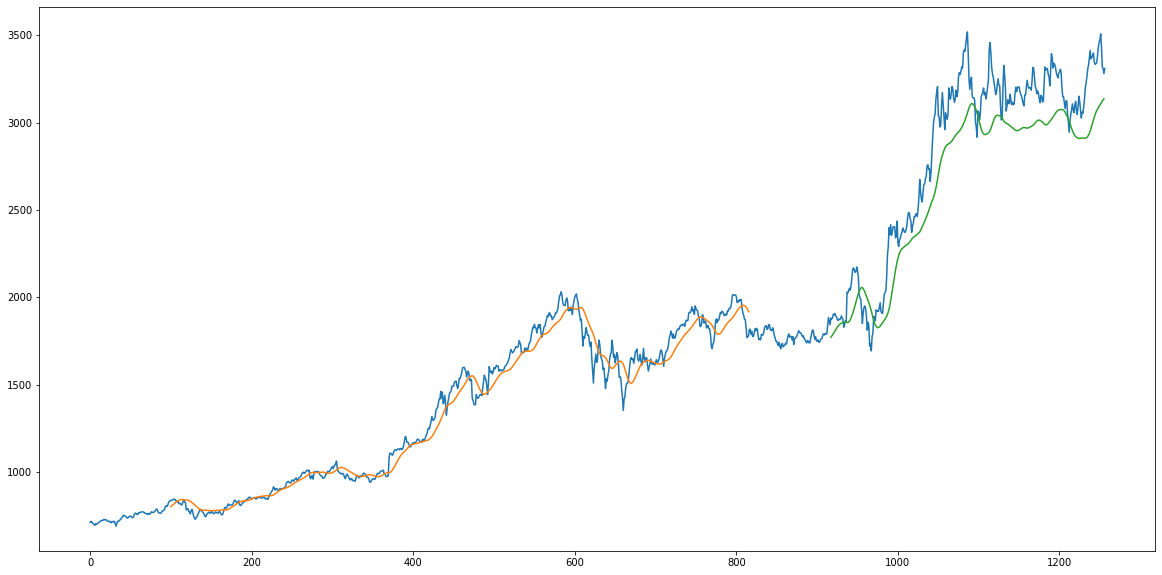

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
x_input=test[test_size-time_step:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input


[0.8723551275995871,
 0.8728003606432548,
 0.8889999972136042,
 0.9020441807464126,
 0.8908268679046711,
 0.885871028805324,
 0.8874805883633068,
 0.8861059818113894,
 0.8819894084454689,
 0.9006625430990134,
 0.928079492511104,
 0.9267897744760027,
 0.9090423898324356,
 0.8899434756690021,
 0.8850706703161326,
 0.8745105959973758,
 0.8806713941203099,
 0.8752473313410047,
 0.863505288634951,
 0.8567491065833384,
 0.8715706855416627,
 0.8691961376362127,
 0.8584416998877993,
 0.8590212103180732,
 0.8967950709725263,
 0.9291837759152315,
 0.923344501470674,
 0.9236925528878528,
 0.9261360727021732,
 0.914250910206591,
 0.910146630127022,
 0.8909187440540711,
 0.9198498397722332,
 0.9558180087111128,
 0.9476466736407152,
 0.9268215644056741,
 0.9365318049696891,
 0.9346395856913454,
 0.9287809439320915,
 0.917492933739765,
 0.9118586771419397,
 0.9071766982928937,
 0.9157155814237898,
 0.9189876265120576,
 0.9245583030738618,
 0.9187826950610856,
 0.8879222844811412,
 0.8691501994731736,

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array
days=30
lst_output=[]
n_steps=100
i=0
while(i<days):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        print(x_input.shape)
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

(1, 100, 1)
[[0.8651318550109863], [0.8638970851898193], [0.8614537715911865], [0.857948362827301], [0.8535947799682617], [0.848615825176239], [0.8432124257087708], [0.8375502228736877], [0.8317581415176392], [0.8259299993515015], [0.8201315402984619], [0.8144057393074036], [0.8087786436080933], [0.8032644987106323], [0.7978696823120117], [0.7925950288772583], [0.7874387502670288], [0.7823969125747681], [0.7774653434753418], [0.772639274597168], [0.7679139971733093], [0.7632854580879211], [0.7587496638298035], [0.7543029189109802], [0.7499419450759888], [0.7456638813018799], [0.7414657473564148], [0.7373449206352234], [0.7332988977432251], [0.7293255925178528]]


In [ ]:
day_new=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+days+1)
print(day_pred)

[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130]


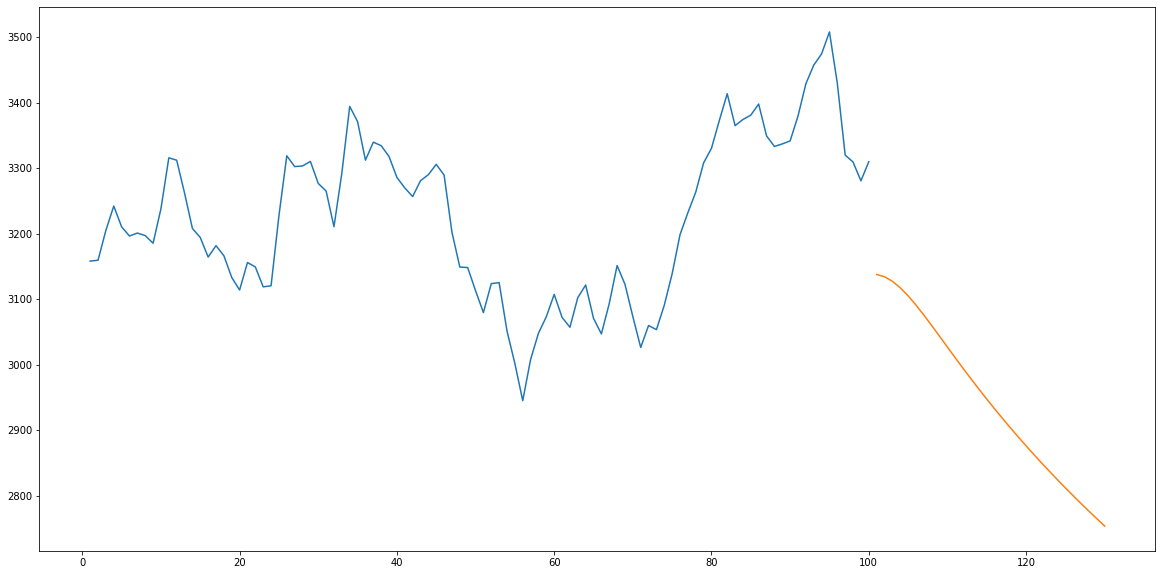

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[train_size+test_size-time_step:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

The LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs.

Stock price is affected by the news about the company and other factors like merger/demerger of the companies, economic conditions etc. There are certain intangible factors as well which can often be impossible to predict beforehand.

**Linear Regression**

In [ ]:
data = pd.read_csv(os.path.join(f'{googlepath}',f'{file_name}'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [ ]:
high_prices = data.loc[:,'High'].to_numpy()
low_prices = data.loc[:,'Low'].to_numpy()
avg_prices = (high_prices+low_prices)/2.0
data['avg_prices'] = avg_prices
data

,Date,Open,High,Low,Close,avg_prices
0,2016-05-11,705.789978,719.000000,701.650024,713.229980,710.325012
1,2016-05-12,717.380005,722.450012,711.510010,717.929993,716.980011
2,2016-05-13,714.640015,719.250000,706.510010,709.919983,712.880005
3,2016-05-16,710.130005,713.250000,700.280029,710.659973,706.765015
4,2016-05-17,709.900024,714.469971,693.909973,695.270020,704.189972
...,...,...,...,...,...,...
1253,2021-05-04,3356.189941,3367.979980,3272.129883,3311.870117,3320.054931
1254,2021-05-05,3338.860107,3354.699951,3264.360107,3270.540039,3309.530029
1255,2021-05-06,3270.000000,3314.399902,3247.199951,3306.370117,3280.799926
1256,2021-05-07,3319.090088,3330.889893,3289.070068,3291.610107,3309.979981


In [ ]:
x = np.array(data.index).reshape(-1, 1)
y = data['avg_prices']

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(x, y)
linreg.score(x, y)
predictions = linreg.predict(x)

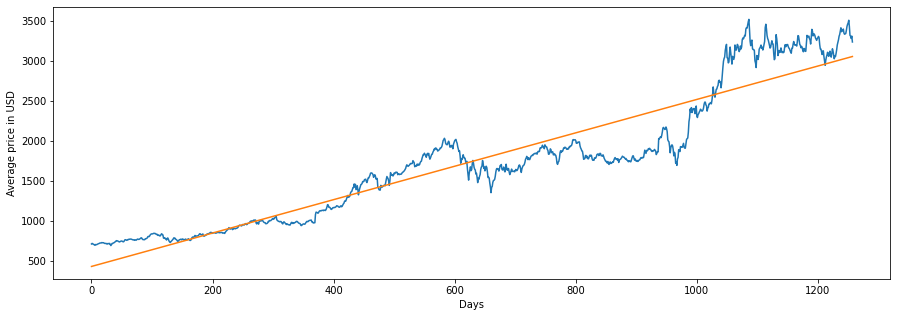

In [ ]:
plt.figure(figsize=(15,5))
plt.ylabel('Average price in USD')
plt.xlabel('Days')
plt.plot(data['avg_prices'])
plt.plot(data.index, predictions)

In [ ]:
rcParams['figure.figsize'] = 20,10

#normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.read_csv(os.path.join(f'{googlepath}',f'{file_name}'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
data.head()

,Date,Open,High,Low,Close
0,2016-05-11,705.789978,719.000000,701.650024,713.229980
1,2016-05-12,717.380005,722.450012,711.510010,717.929993
2,2016-05-13,714.640015,719.250000,706.510010,709.919983
3,2016-05-16,710.130005,713.250000,700.280029,710.659973
4,2016-05-17,709.900024,714.469971,693.909973,695.270020


In [ ]:
high_prices = data.loc[:,'High'].to_numpy()
low_prices = data.loc[:,'Low'].to_numpy()
avg_prices = (high_prices+low_prices)/2.0
data['avg_prices'] = avg_prices
data

,Date,Open,High,Low,Close,avg_prices
0,2016-05-11,705.789978,719.000000,701.650024,713.229980,710.325012
1,2016-05-12,717.380005,722.450012,711.510010,717.929993,716.980011
2,2016-05-13,714.640015,719.250000,706.510010,709.919983,712.880005
3,2016-05-16,710.130005,713.250000,700.280029,710.659973,706.765015
4,2016-05-17,709.900024,714.469971,693.909973,695.270020,704.189972
...,...,...,...,...,...,...
1253,2021-05-04,3356.189941,3367.979980,3272.129883,3311.870117,3320.054931
1254,2021-05-05,3338.860107,3354.699951,3264.360107,3270.540039,3309.530029
1255,2021-05-06,3270.000000,3314.399902,3247.199951,3306.370117,3280.799926
1256,2021-05-07,3319.090088,3330.889893,3289.070068,3291.610107,3309.979981


In [314]:
#setting index as date values
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']
dataset = data.sort_index(ascending=True, axis=0)

#creating a new dataset with Date and average prices
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'avg_prices'])
for i in range(0,len(dataset)):
    new_data['Date'][i] = data['Date'][i]
    new_data['avg_prices'][i] = data['avg_prices'][i]
new_data.head(5)

,Date,avg_prices
0,2016-05-11 00:00:00,710.325
1,2016-05-12 00:00:00,716.98
2,2016-05-13 00:00:00,712.88
3,2016-05-16 00:00:00,706.765
4,2016-05-17 00:00:00,704.19


In [ ]:
#creating features
from fastai.tabular import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True) 
new_data.head(5)

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


,avg_prices,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,710.325,2016,5,19,11,2,132,False,False,False,False,False,False
1,716.98,2016,5,19,12,3,133,False,False,False,False,False,False
2,712.88,2016,5,19,13,4,134,False,False,False,False,False,False
3,706.765,2016,5,20,16,0,137,False,False,False,False,False,False
4,704.19,2016,5,20,17,1,138,False,False,False,False,False,False


In [ ]:
#split into train set and validation set
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('avg_prices', axis=1)
y_train = train['avg_prices']
x_valid = valid.drop('avg_prices', axis=1)
y_valid = valid['avg_prices']

#implementing linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Making predictions
preds = model.predict(x_valid)

     avg_prices  Year  Month  ...  Is_quarter_start  Is_year_end  Is_year_start
987      2239.1  2020      4  ...             False        False          False
988     2289.19  2020      4  ...             False        False          False
989        2398  2020      4  ...             False        False          False
990     2358.01  2020      4  ...             False        False          False
991     2415.52  2020      4  ...             False        False          False
...         ...   ...    ...  ...               ...          ...            ...
1253    3320.05  2021      5  ...             False        False          False
1254    3309.53  2021      5  ...             False        False          False
1255     3280.8  2021      5  ...             False        False          False
1256    3309.98  2021      5  ...             False        False          False
1257     3236.5  2021      5  ...             False        False          False

[271 rows x 13 columns]
[2095.252891 20

In [315]:
#caluclating Root Mean Square Error
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

811.0788395036105

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


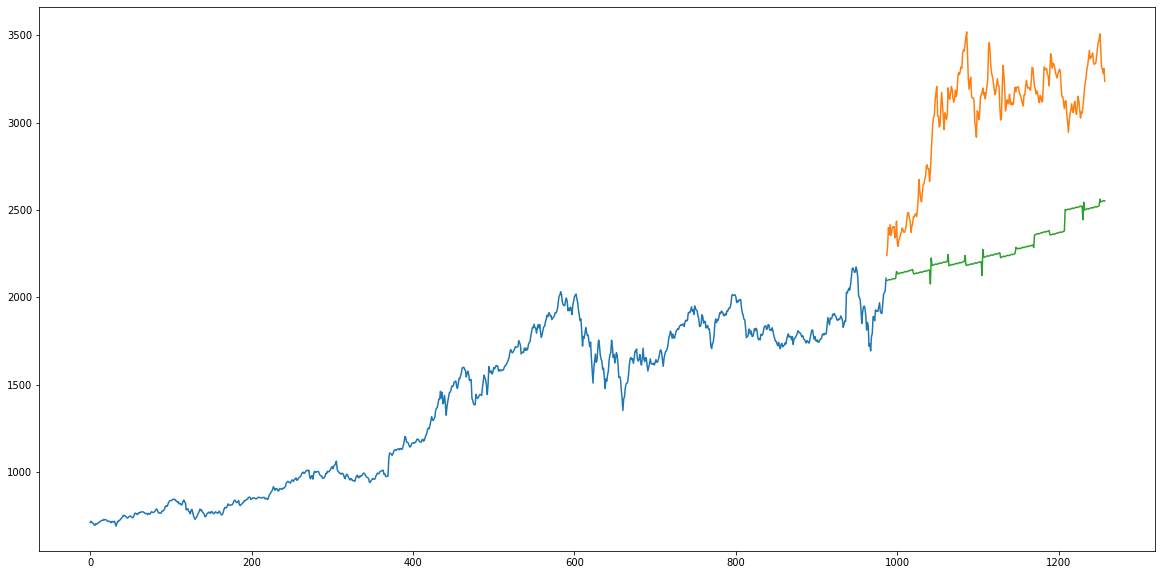

In [ ]:
#plot graph between Train data, Test data, and validation data
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[987:].index
train.index = new_data[:987].index

plt.plot(train['avg_prices'])
plt.plot(valid[['avg_prices', 'Predictions']])